
# XAI Playground (TensorFlow/Keras): Grad-CAM / Grad-CAM++ / Guided Backprop / Integrated Gradients

**Created:** 2025-11-12 19:46:34

This notebook applies and compares multiple explainability methods for **TensorFlow/Keras** classifiers
(e.g., your KimiaNet model). It produces overlays and a side-by-side grid and includes a simple **faithfulness**
check (deletion curve).

### Included methods
- **Grad-CAM**
- **Grad-CAM++**
- **Guided Backpropagation**
- **Integrated Gradients**
- (Optional) **SmoothGrad** for vanilla saliency

### What you'll get
- Heatmaps over the original image
- A comparison grid across methods
- Basic faithfulness diagnostic (how quickly confidence falls when masking top-attribution pixels)

> Plug in your existing model from `Kather_KimiaNet_Classifier.ipynb` by assigning it to `model` and setting (or auto-detecting) `TARGET_LAYER`.



> **Environment note:** We implement methods with **TensorFlow 2 / Keras** using only `tensorflow`, `numpy`, and `matplotlib`.
GPU is optional but recommended. Guided Backprop uses a custom ReLU with a modified gradient via `@tf.custom_gradient`.


In [6]:


import os
import numpy as np
from typing import Dict, Optional

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import Image 

print("TensorFlow:", tf.__version__)
print("Physical GPUs:", len(tf.config.list_physical_devices('GPU')))


TensorFlow: 2.20.0
Physical GPUs: 0


In [7]:

# --- Image & Visualization Utilities ---

def to_numpy(x):
    if isinstance(x, tf.Tensor):
        x = x.numpy()
    return x

def denorm(img, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    # img: [H,W,3] or [1,H,W,3] normalized image; return in [0,1]
    img = tf.convert_to_tensor(img)
    if img.ndim == 4:
        img0 = img[0]
    else:
        img0 = img
    mean_t = tf.constant(mean, dtype=img0.dtype)[None, None, :]
    std_t  = tf.constant(std, dtype=img0.dtype)[None, None, :]
    out = img0 * std_t + mean_t
    return tf.clip_by_value(out, 0., 1.)

def show_image(img, title=None):
    if isinstance(img, tf.Tensor):
        img = img.numpy()
    if img.ndim == 3 and img.shape[-1] == 3:
        pass
    elif img.ndim == 4:
        img = img[0]
    else:
        raise ValueError("Expected image [H,W,3] or [1,H,W,3]")
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

def overlay_heatmap(img, heatmap, alpha=0.45):
    import matplotlib.cm as cm
    if isinstance(img, tf.Tensor):
        img = img.numpy()
    if img.ndim == 4:
        img = img[0]
    img = np.clip(img, 0, 1)
    h = heatmap
    h = (h - h.min()) / (h.max() - h.min() + 1e-8)
    heatmap_rgb = cm.jet(h)[...,:3]
    overlay = (1 - alpha) * img + alpha * heatmap_rgb
    plt.figure()
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()
    return overlay

def standard_preprocess(image_path,image_size=224):

   with Image.open(image_path) as img:
        # Convert to RGB if necessary
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize image
        img = img.resize((image_size, image_size), Image.Resampling.LANCZOS)
        
        # Convert to numpy array
        img_array = np.array(img, dtype=np.float32)
        
        # Normalize to [0, 1]
        img_array = img_array / 255.0
        
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)

        return img_array



## 1) Load your model and select a target layer

- Assign your `tf.keras.Model` to `model` and set it to `eval` mode (Keras default is inference when not in `.fit()`).
- Set `TARGET_LAYER` to the **last convolutional** layer (for Grad-CAM/Grad-CAM++). If not sure, we try to auto-detect.


In [8]:

# Load the model from the specified path
model = keras.models.load_model(os.path.join('kather_kimianet_workspace', 'artifacts', 'kimianet_kather_classifier.keras'))
def find_last_conv_layer(m):
    last = None
    for layer in m.layers[::-1]:
        if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D, keras.layers.DepthwiseConv2D)):
            last = layer
            break
    return last

TARGET_LAYER = None

if model is not None:
    TARGET_LAYER = find_last_conv_layer(model)
    print("Auto-detected target layer:", TARGET_LAYER.name if TARGET_LAYER is not None else None)
else:
    print("Please run Kather_KimiaNet_Classifier.ipynb")


Auto-detected target layer: conv5_block16_2_conv


In [9]:

# --- Prediction helpers ---
def softmax(x):
    x = np.array(x, dtype=np.float64)
    e = np.exp(x - x.max())
    return e / (e.sum() + 1e-12)

def predict_logits(model, x):
    y = model(x, training=False)
    if isinstance(y, (list, tuple)):
        y = y[0]
    return y

def get_pred_and_score(logits, target=None):
    # logits: [1,C]
    probs = tf.nn.softmax(logits, axis=-1)
    pred = int(tf.argmax(probs[0]).numpy())
    score = probs[0, pred] if target is None else probs[0, target]
    return pred, score


In [10]:

# --- Grad-CAM & Grad-CAM++ ---

def _make_cam_model(model, target_layer):
    # Returns a model that outputs [conv_acts, preds]
    conv_output = target_layer.output
    preds = model.output
    return keras.Model(inputs=model.inputs, outputs=[conv_output, preds])

def grad_cam(model, target_layer, x, target_class=None):
    cam_model = _make_cam_model(model, target_layer)
    with tf.GradientTape() as tape:
        conv_out, preds = cam_model(x, training=False)
        if target_class is None:
            target_class = tf.argmax(preds[0])
        score = preds[:, target_class]
    grads = tape.gradient(score, conv_out)  # dY/dA
    weights = tf.reduce_mean(grads, axis=(1,2), keepdims=True)  # global average pooling over HxW
    cam = tf.nn.relu(tf.reduce_sum(weights * conv_out, axis=-1))  # [N,H,W]
    cam = cam[0]
    cam = (cam - tf.reduce_min(cam)) / (tf.reduce_max(cam) - tf.reduce_min(cam) + 1e-8)
    cam = cam.numpy()
    # Upsample to input size
    cam = tf.image.resize(cam[..., None], x.shape[1:3], method='bilinear')[...,0].numpy()
    return cam

def grad_cam_pp(model, target_layer, x, target_class=None):
    cam_model = _make_cam_model(model, target_layer)
    with tf.GradientTape() as tape:
        conv_out, preds = cam_model(x, training=False)
        if target_class is None:
            target_class = tf.argmax(preds[0])
        score = preds[:, target_class]
    grads = tape.gradient(score, conv_out)  # [N,H,W,C]
    first = grads
    second = grads * grads
    third = grads * grads * grads
    conv = conv_out

    # alpha computation per Grad-CAM++
    eps = 1e-8
    sum_conv = tf.reduce_sum(conv, axis=(1,2), keepdims=True)  # [N,1,1,C]
    denom = 2.0 * second * conv + sum_conv * third + eps  # [N,H,W,C]
    alpha = second / denom  # [N,H,W,C]
    weights = tf.reduce_sum(alpha * tf.nn.relu(first), axis=(1,2), keepdims=True)  # [N,1,1,C]

    cam = tf.nn.relu(tf.reduce_sum(weights * conv, axis=-1))  # [N,H,W]
    cam = cam[0]
    cam = (cam - tf.reduce_min(cam)) / (tf.reduce_max(cam) - tf.reduce_min(cam) + 1e-8)
    cam = cam.numpy()
    cam = tf.image.resize(cam[..., None], x.shape[1:3], method='bilinear')[...,0].numpy()
    return cam


In [11]:

# --- Guided Backpropagation ---
# We implement a custom ReLU with modified backprop: allow only positive gradients where inputs were positive.

@tf.custom_gradient
def guided_relu(x):
    y = tf.nn.relu(x)
    def grad(dy):
        gate_f = tf.cast(x > 0.0, x.dtype)
        gate_r = tf.cast(dy > 0.0, dy.dtype)
        return dy * gate_f * gate_r
    return y, grad

def _clone_with_guided_relu(model):
    # Rebuild the model graph replacing ReLU activations with guided_relu via tf.keras.layers.Lambda
    def convert(layer):
        cfg = layer.get_config()
        if isinstance(layer, keras.layers.ReLU):
            return keras.layers.Activation(guided_relu, name=layer.name + "_guided")
        if 'activation' in cfg and cfg['activation'] == 'relu':
            # For layers with built-in 'relu' activation, wrap as Lambda on top
            base = layer.__class__.from_config(cfg)
            inp = keras.Input(shape=layer.input_shape[1:])
            out = base(inp)
            out = keras.layers.Lambda(lambda z: guided_relu(z))(out)
            guided = keras.Model(inp, out, name=layer.name + "_guidedwrap")
            return guided
        return layer

    # Functional API rebuild
    if not isinstance(model, keras.Model):
        raise ValueError("Expected a tf.keras.Model")
    # Handle simple Sequential / Functional
    try:
        # Attempt to rebuild by iterating layers in order (works for Sequential or simple graphs)
        inputs = keras.Input(shape=model.input_shape[1:])
        x = inputs
        for layer in model.layers:
            new_layer = convert(layer)
            x = new_layer(x)
        guided_model = keras.Model(inputs, x, name=model.name + "_guided")
        # Transfer weights where shapes match
        for l_old, l_new in zip(model.layers, guided_model.layers[1:]):  # skip inputs
            try:
                l_new.set_weights(l_old.get_weights())
            except Exception:
                pass
        return guided_model
    except Exception as e:
        print("Guided backprop rebuild fallback (gradient override on-the-fly).", e)
        # Fallback: return original model and compute saliency with guided_relu applied via tf.nn at call sites
        return None  # signal to use fallback path

def guided_backprop_saliency(model, x, target_class=None):
    # Try cloned guided model first
    gmodel = _clone_with_guided_relu(model)
    if gmodel is not None:
        with tf.GradientTape() as tape:
            tape.watch(x)
            logits = gmodel(x, training=False)
            if target_class is None:
                target_class = tf.argmax(logits[0])
            score = logits[:, target_class]
        grads = tape.gradient(score, x)[0]  # HWC
    else:
        # Fallback: apply guided relu via custom forward pass using GradientTape and replacing relu with guided manually isn't trivial here.
        # We'll approximate by using vanilla gradient and then zeroing negative grads & inputs.
        with tf.GradientTape() as tape:
            tape.watch(x)
            logits = model(x, training=False)
            if target_class is None:
                target_class = tf.argmax(logits[0])
            score = logits[:, target_class]
        grads = tape.gradient(score, x)[0]
        grads = tf.nn.relu(grads) * tf.cast(x[0] > 0.0, grads.dtype)

    # Aggregate channels to a 2D saliency map
    sal = tf.reduce_max(tf.abs(grads), axis=-1)  # [H,W]
    sal = (sal - tf.reduce_min(sal)) / (tf.reduce_max(sal) - tf.reduce_min(sal) + 1e-8)
    return sal.numpy()


In [12]:

# --- Integrated Gradients & SmoothGrad ---

def integrated_gradients(model, x, target_class=None, steps=50, baseline=None):
    x = tf.convert_to_tensor(x)
    if baseline is None:
        baseline = tf.zeros_like(x)
    alphas = tf.linspace(0.0, 1.0, steps)
    total_grad = tf.zeros_like(x)

    for a in alphas:
        xi = baseline + a * (x - baseline)
        with tf.GradientTape() as tape:
            tape.watch(xi)
            logits = model(xi, training=False)
            if target_class is None:
                target_class = tf.argmax(logits[0])
            score = logits[:, target_class]
        grad = tape.gradient(score, xi)
        total_grad += grad

    avg_grad = total_grad / tf.cast(steps, x.dtype)
    ig = (x - baseline) * avg_grad
    ig = tf.reduce_mean(tf.abs(ig[0]), axis=-1)  # [H,W]
    ig = (ig - tf.reduce_min(ig)) / (tf.reduce_max(ig) - tf.reduce_min(ig) + 1e-8)
    return ig.numpy()

def vanilla_grad(model, x, target_class=None):
    with tf.GradientTape() as tape:
        tape.watch(x)
        logits = model(x, training=False)
        if target_class is None:
            target_class = tf.argmax(logits[0])
        score = logits[:, target_class]
    grad = tape.gradient(score, x)[0]
    sal = tf.reduce_mean(tf.abs(grad), axis=-1)  # [H,W]
    sal = (sal - tf.reduce_min(sal)) / (tf.reduce_max(sal) - tf.reduce_min(sal) + 1e-8)
    return sal.numpy()

def smoothgrad(model, x, target_class=None, nsamples=25, noise_sigma=0.15):
    grads = []
    for i in range(nsamples):
        noise = tf.random.normal(tf.shape(x), stddev=noise_sigma)
        sal = vanilla_grad(model, x + noise, target_class)
        grads.append(sal)
    sm = np.mean(np.stack(grads, axis=0), axis=0)
    sm = (sm - sm.min()) / (sm.max() - sm.min() + 1e-8)
    return sm


In [13]:

# --- Comparison Grid ---
def compare_methods(model, target_layer, x, label_names: Optional[Dict[int,str]]=None, target_class: Optional[int]=None, run_smoothgrad: bool=False):
    logits = predict_logits(model, x)
    pred, score = get_pred_and_score(logits, target_class)
    cls = target_class if target_class is not None else pred
    title_cls = label_names.get(cls, str(cls)) if label_names else str(cls)
    print(f"Predicted class: {pred}  (visualizing class: {cls} -> '{title_cls}')")

    # Prepare a denormalized version for overlay (if your input is normalized)
    try:
        x_vis = denorm(x)
    except Exception:
        x_vis = tf.clip_by_value(x, 0., 1.)

    methods = {}
    if target_layer is None:
        try:
            target_layer = find_last_conv_layer(model)
            print("Auto-selected target layer:", target_layer.name if target_layer is not None else None)
        except Exception:
            pass

    try:
        methods['Grad-CAM'] = grad_cam(model, target_layer, x, target_class=cls)
    except Exception as e:
        print("Grad-CAM failed:", e)
    try:
        methods['Grad-CAM++'] = grad_cam_pp(model, target_layer, x, target_class=cls)
    except Exception as e:
        print("Grad-CAM++ failed:", e)
    try:
        methods['Guided Backprop'] = guided_backprop_saliency(model, x, target_class=cls)
    except Exception as e:
        print("Guided Backprop failed:", e)
    try:
        methods['Integrated Gradients'] = integrated_gradients(model, x, target_class=cls, steps=50)
    except Exception as e:
        print("Integrated Gradients failed:", e)
    if run_smoothgrad:
        try:
            methods['SmoothGrad (vanilla)'] = smoothgrad(model, x, target_class=cls, nsamples=20, noise_sigma=0.15)
        except Exception as e:
            print("SmoothGrad failed:", e)

    # Show original
    show_image(x_vis, title=f"Original (class: {title_cls})")
    # Overlays
    for name, m in methods.items():
        print(f"\n{name}")
        overlay_heatmap(x_vis, m, alpha=0.45)
    return methods


In [14]:

# --- Simple Faithfulness Check: Deletion Curve ---
def deletion_curve(model, x, attribution, k_steps=20, mask_value=0.0, target_class=None):
    H, W = attribution.shape
    Npix = H * W
    flat_idx = np.argsort(attribution.reshape(-1))[::-1]  # descending
    xs = []
    probs = []

    logits = predict_logits(model, x)
    pred, _ = get_pred_and_score(logits, target_class)
    cls = target_class if target_class is not None else pred

    step = max(1, Npix // k_steps)
    for i in range(k_steps+1):
        frac = i / k_steps
        xs.append(frac)
        n = min(i*step, Npix)
        idx = flat_idx[:n]
        rr = idx // W
        cc = idx % W
        x_masked = x.numpy().copy()
        x_masked[0, rr, cc, :] = mask_value
        logits = predict_logits(model, tf.convert_to_tensor(x_masked))
        _, sc = get_pred_and_score(logits, cls)
        probs.append(float(sc.numpy()))
    return xs, probs

def plot_deletion(xs, probs, title="Deletion Curve (lower is better)"):
    plt.figure()
    plt.plot(xs, probs, marker='o')
    plt.xlabel('Fraction of top-attribution pixels removed')
    plt.ylabel('Class probability')
    plt.title(title)
    plt.grid(True)
    plt.show()



## 2) Load and preprocess an image

Update `IMAGE_PATH` to a representative sample. Adjust preprocessing to match your model's training pipeline if needed.


In [22]:

# --- Image loading (edit path) ---
from PIL import Image

# IMAGE_PATH = r'kather_kimianet_workspace\data\Kather_texture_2016_image_tiles_5000\03_COMPLEX\18548_CRC-Prim-HE-10_025.tif_Row_901_Col_151.tif'  # <-- change to your image path
IMAGE_PATH = r"kather_kimianet_workspace\data\Kather_texture_2016_image_tiles_5000\01_TUMOR\17E8F_CRC-Prim-HE-02_007.tif_Row_151_Col_301.tif"
if os.path.exists(IMAGE_PATH):
    x = standard_preprocess(IMAGE_PATH,image_size=224)

    print("Image loaded:", x.shape)
else:
    # Fallback dummy

    print("No image at IMAGE_PATH.")
    

x = tf.convert_to_tensor(x)


Image loaded: (1, 224, 224, 3)



## 3) Run comparisons

- Ensure `model` and `TARGET_LAYER` are set (or auto-detected).
- Optionally pass a `target_class`.


Predicted class: 0  (visualizing class: 0 -> '0')
Guided backprop rebuild fallback (gradient override on-the-fly). too many positional arguments


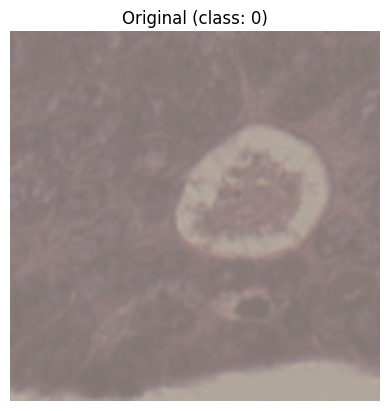


Grad-CAM


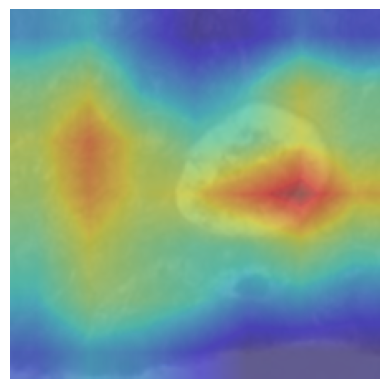


Grad-CAM++


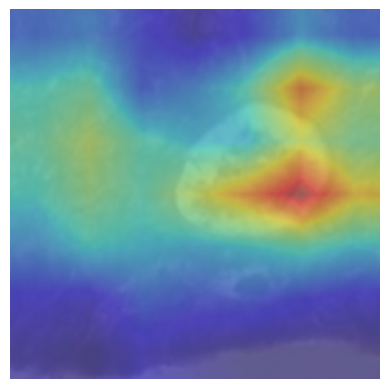


Guided Backprop


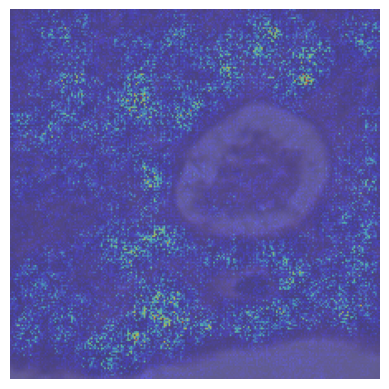


Integrated Gradients


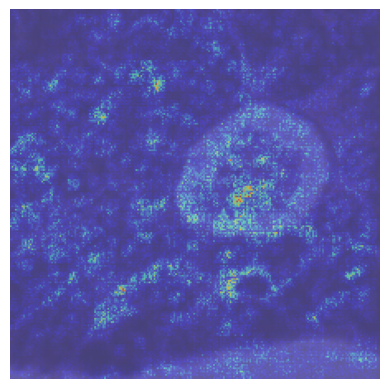


SmoothGrad (vanilla)


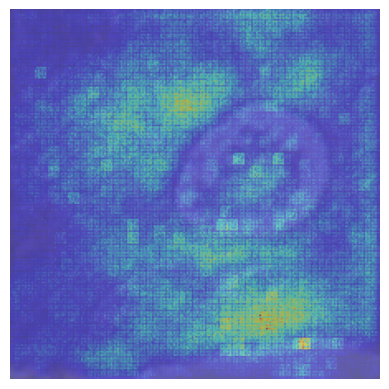

In [23]:
methods = compare_methods(model, TARGET_LAYER, x, label_names=None, target_class=None, run_smoothgrad=True)



## 4) Quick faithfulness check

Pick one attribution (e.g., from Grad-CAM or Integrated Gradients) and run a **deletion curve**. A more faithful map typically leads to a sharper probability drop.


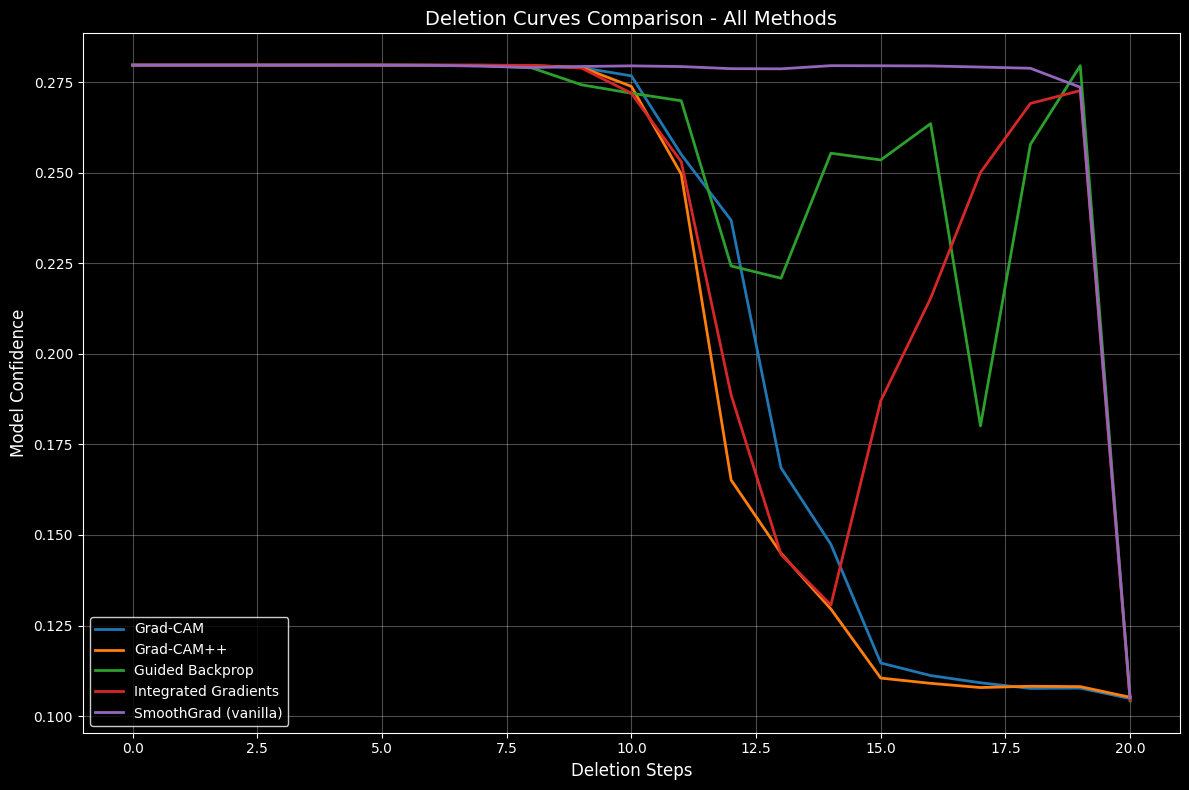

In [24]:
try:
    if methods:
        # Create a figure for comparing all methods

        plt.figure(figsize=(12, 8), facecolor='black')
        ax = plt.gca()
        ax.set_facecolor('black')

        # Store deletion curves for all methods
        all_curves = {}

        for method_name, attr in methods.items():
            # Generate deletion curve for each method
            xs, probs = deletion_curve(model, x, attr, k_steps=20, mask_value=0.0, target_class=None)
            all_curves[method_name] = (xs, probs)

            # Plot each curve
            plt.plot(range(len(probs)), probs, label=method_name, linewidth=2)

        # Customize the plot





        plt.xlabel('Deletion Steps', fontsize=12, color='white')
        plt.ylabel('Model Confidence', fontsize=12, color='white')
        plt.title('Deletion Curves Comparison - All Methods', fontsize=14, color='white')
        plt.legend(loc='best', facecolor='black', edgecolor='white', labelcolor='white')
        plt.grid(True, alpha=0.3, color='white')
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white')
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        plt.tight_layout()
        plt.show()
    else:
        print("Run the comparison to populate `methods`.")

except NameError:
    print("Run the comparison section first." )
